In [35]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from collections import Counter
#from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")




"""
# deep learning portion
#from tqdm import tqdm
#from attention import AttentionLayer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping;""";


In [2]:
# import cover_letters and check size, types and entries
df = pd.read_csv('cover_letters.csv')
df = df[['raw_title', 'raw']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 2 columns):
raw_title    1670 non-null object
raw          1663 non-null object
dtypes: object(2)
memory usage: 26.2+ KB


In [3]:
# dropping NaN values from raw cloumn and reset index for new numbering
df.dropna(inplace = True)
df.reset_index(drop= True, inplace = True)

In [4]:
# Ensuring all NaN are deleted
df.loc[df.raw.isnull() == True]

,raw_title,raw


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 2 columns):
raw_title    1663 non-null object
raw          1663 non-null object
dtypes: object(2)
memory usage: 26.1+ KB


In [6]:
# assess df
df.head()

,raw_title,raw
0,3D Animator Cover Letter,"Dear Mr. Butler:,I saw that MasterClass Animat..."
1,Academic Coordinator Cover Letter,"Dear Ms. Rodriguez:,Upon learning of your sear..."
2,Academic Advisor Cover Letter,"Dear Mr. Lewis:,Upon learning of your search f..."
3,Accounting Associate Cover Letter,"Dear Mr. Saunders:,Upon learning of Dean & McK..."
4,Account Manager Cover Letter,"Dear Ms. Edith Byrd:,As a successful Account M..."


In [7]:
# drop cover letter from the raw title
df['title'] = df.raw_title.apply(lambda line: ' '.join(line.split(' ')[:-2]))

In [8]:
# drop raw title in place of cleaned version of the title 
df.drop('raw_title', axis = 1, inplace = True)

In [9]:
# inspect the format of the raw text 
df.raw[1600]

'Dear Mr. Padula:,Upon learning of your posting for an apprentice plumber, I eagerly decided to submit my resume for your review. As a skilled and detail-oriented emerging professional with recent vocational training and hands-on support experience in various residential plumbing tasks, I would be a valuable asset to your business in this role.,My background includes assisting plumbers in a variety of plumbing projects encompassing sewer lines, drain repairs, water and gas pipe repairs, system installations, and other service and repair jobs. Equipped with a proven ability to use hand and power tools properly – as well as a solid commitment to achieving accurate and deadline-driven results – I am prepared to excel at providing outstanding support to plumbers while acquiring the skills and experience necessary to advance in my own plumbing career.,The following achievements demonstrate my qualifications for this position:,With my skills and qualifications, coupled with my goal of buildi

# Cleaning raw sentences
<ol>
1. Split according to newlines <br>
2. Filter out empty strings to clean <br>
3. Eliminate dear, thank you and sincerely sentences <br>
4. Ensure proper punctuation throughout
    </ol>
  

In [10]:
# testing cell for sentences
#split according to newline/ sentences
sent = df.raw[125].split(',')
# filter out empty strings caused from the split
sent = list(filter(None, sent)) 
# eliminate dear, thank you and sincerely by indexing
sent = sent[1:-3]
# finally join with proper punctuation and 
clean_sent = []
for element in sent:
    if element.endswith('.'):
        clean_sent.append(element)
    else:
        clean_sent.append(element+',')
print(''.join(clean_sent))

I am writing you to express my interest in interviewing for the position of Data Scientist. With my Masters degree in Data Science and eight years of experience as a Data Scientist under my belt, I think I can be a great asset to your organization.My professional experience includes crafting algorithms and making use of machine learning to mine and make sense of data, and then using data visualization to present said data to decision makers. Couple this experience with my passion for data and I think I’d be an excellent fit at Kolt Insights.The following are my most relevant qualifications and accomplishments.What separates me from other candidates with similar qualifications are my written and verbal communication skills. I ,talking about data and thrive on explaining the meaning of data to non-technical stakeholders. If you think I’d be a good fit for Kolt Insights,


In [11]:
def sentence_cleaner(text):
    """Uses.apply to create a clean paragraph with sentences using clean punctuation and format"""
    # Split according to newlines
    clean = text.split(',')
    # Filter out empty strings to clean
    cleaner = list(filter(None, clean)) 
    # Eliminate dear, thank you and sincerely sentences
    cleaner = cleaner[1:-3]
    # Ensure proper punctuation throughout
    cleanest = []
    for element in cleaner:
        if element.endswith('.'):
            cleanest.append(element)
        else:
            cleanest.append(element + ',')
    
    return ''.join(cleanest)

In [12]:
df['paragraph'] = df.raw.apply(sentence_cleaner)

In [13]:
df.head()

,raw,title,paragraph
0,"Dear Mr. Butler:,I saw that MasterClass Animat...",3D Animator,I saw that MasterClass Animation was hiring a ...
1,"Dear Ms. Rodriguez:,Upon learning of your sear...",Academic Coordinator,Upon learning of your search for an organized ...
2,"Dear Mr. Lewis:,Upon learning of your search f...",Academic Advisor,Upon learning of your search for an Academic A...
3,"Dear Mr. Saunders:,Upon learning of Dean & McK...",Accounting Associate,Upon learning of Dean & McKowski’s need for a ...
4,"Dear Ms. Edith Byrd:,As a successful Account M...",Account Manager,As a successful Account Manager with experienc...


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 3 columns):
raw          1663 non-null object
title        1663 non-null object
paragraph    1663 non-null object
dtypes: object(3)
memory usage: 39.1+ KB


# Cleaning raw text 
<ol> 1. Convert everything to lowercase <br>
2. Expanding contractions through contraction mapping <br>
3. Remove ('s) <br>
4. Remove any text inside parenthesis <br>
5. Eliminate punctuation, numbers and special characters <br>
6. Remove stop words <br>
</ol>

In [15]:
# dictionary used for expanding contractions from aravindpai/github
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [16]:
# regex testing cell 

# stop_words = set(stopwords.words('english')) 
# begin defining future function extracting one observation from df
test = df.paragraph[508]
# replacing ’ character with ' to align with format in dictionary and regex
test = re.sub(r"’", "'", test)
# Expanding contractions through contraction mapping
test = ' '.join([contraction_mapping[word] if word in contraction_mapping else word for word in test.split(" ")])
# Convert everything to lowercase
test = test.lower()
# Remove ('s)
test = re.sub(r"'s\b", "", test)
# Remove any text inside parenthesis
#test = re.sub(r'\([^)]*\)', '', test)
# Eliminate punctuation, numbers and special characters
test = re.sub("[^a-zA-Z]", " ", test) 
test = re.sub('"','', test)
# clean up the spaces 
test = re.sub(' +', ' ', test)





# Remove stop words
#test = [w for w in test.split() if not w in stop_words]
print(test)

upon learning of your need for a travel consultant to join your company i was eager to send along my resume for your review as a personable organized and self motivated professional with more than eight years of experience providing comprehensive travel planning and support to a broad range of clients i am confident that i would quickly become a valuable asset to your team my expertise lies in coordinating and booking airline accommodation transportation reservations for individuals groups and businesses while responding to and resolving customer questions and concerns complemented by my superior communication and multitasking skills i excel at leveraging my deep expertise in travel operations as well as my first hand knowledge of desirable destinations to facilitate excellent travel experiences and stimulate high levels of client retention and referrals additional highlights of my experience include with my proven commitment to delivering the highest caliber of travel planning and sup

In [17]:
 def text_cleaner(text):
    """Uses .apply to clean each row of raw text within df by using standard rules applied to cleaning textual data"""
    # replacing ’ character with ' to align with format in dictionary and regex
    cleaner = re.sub(r"’", "'", text)
    # Expanding contractions through contraction mapping
    cleaner = ' '.join([contraction_mapping[word] if word in contraction_mapping else word for word in cleaner.split(" ")])
    # Convert everything to lowercase
    cleaner = cleaner.lower()
    # Remove ('s)
    cleaner = re.sub(r"'s\b", "", cleaner)
    # Remove any text inside parenthesis
    cleaner = re.sub(r'\([^)]*\)', '', cleaner)
    # Eliminate punctuation, numbers and special characters
    cleaner = re.sub("[^a-zA-Z]", " ", cleaner) 
    cleaner = re.sub('"','', cleaner)
    # clean up the spaces 
    cleanest = re.sub(' +', ' ', cleaner)
    return cleanest

In [18]:
def stop_words(text):
    """remove all stop words, used as a seperate function to test results with and without"""
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if not word in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:        #removing short word as a test also
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [19]:
# testing functions
stop_words(text_cleaner(df.paragraph[125]))

'writing express interest interviewing position data scientist masters degree data science eight years experience data scientist belt think great asset organization professional experience includes crafting algorithms making use machine learning mine make sense data using data visualization present said data decision makers couple experience passion data think would excellent fit kolt insights following relevant qualifications accomplishments separates candidates similar qualifications written verbal communication skills talking data thrive explaining meaning data non technical stakeholders think would good fit kolt insights'

In [20]:
# creation of ne column of clean text and delete raw column of text
df['stop_text'] = df.paragraph.apply(text_cleaner).apply(stop_words)
df['nostop_text'] = df.paragraph.apply(text_cleaner)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 5 columns):
raw            1663 non-null object
title          1663 non-null object
paragraph      1663 non-null object
stop_text      1663 non-null object
nostop_text    1663 non-null object
dtypes: object(5)
memory usage: 65.0+ KB


# EDA

In [22]:
counter = Counter()
count = 0
for t in df['stop_text']:
    t_arr = t.split()
    counter.update(t_arr)
    count = count + 1
    if count == 1663:
        break

In [23]:
stopwords_cover_letter = ['appreciate', 'thank', 'consideration', 'position', 
                         'look', 'forward', 'discussing', 'detail', 'please', 
                          'accept', 'hearing', 'resume', 'would', 'include', 
                          'submit', 'years', 'make', 'positions', 'upon']
keywords = []
for w in counter.most_common():
    if w[0] not in stopwords_cover_letter:
        keywords.append(w)

In [24]:
# Amount of words in corpus
print("There are a total of", len(keywords), "within the stop_text corpus.")
# augmentation should be applied to increase the number of words and the context involved

There are a total of 7021 within the stop_text corpus.


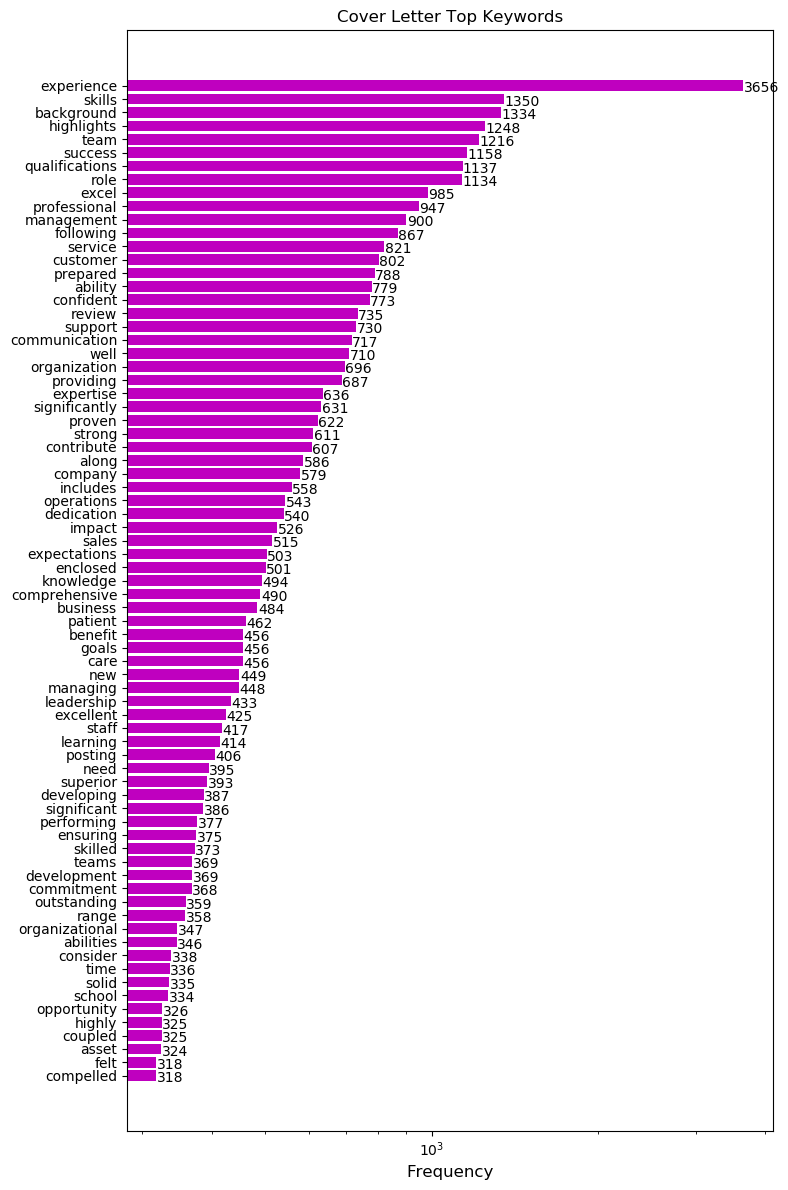

In [27]:
# Most common keywords in corpus
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))
key = [k[0] for k in keywords[:75]] 
value = [k[1] for k in keywords[:75]] 
y_pos = np.arange(len(key))

ax.barh(y_pos, value, align='center', color='m', ecolor='burlywood', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 

for i, v in enumerate(value):
    ax.text(v + 1, i + .50, str(v), color='black', fontsize=10)
    
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title('Cover Letter Top Keywords', fontsize=12)

plt.tight_layout()


In [ ]:
# Show the word cloud forming by keywords that are the most common
wordcloud = WordCloud(max_font_size=100, max_words=100, 
                      width=1280, height=900, colormap='tab10',
                      background_color="white").generate_from_frequencies(dict(keywords))
plt.figure(figsize=(20, 16));
plt.imshow(wordcloud, interpolation="bilinear");
plt.axis("off");


In [29]:
# Number of least common words and the percentage of words that have only one occurance
least_common = counter.most_common()[-2548:]
print((2548 / 7021), '% of words only occur once.')


0.3629112662013958 % of words only occur once.


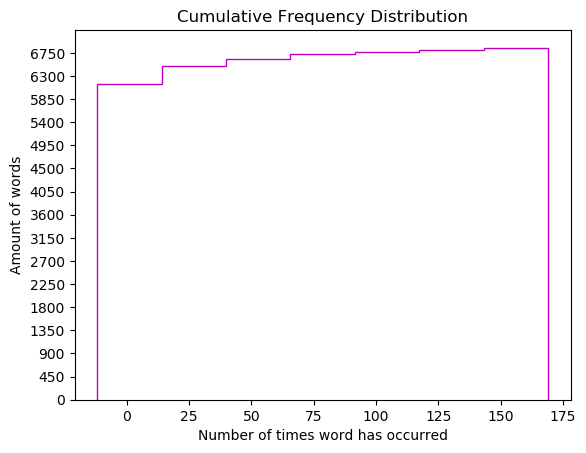

In [30]:
# distribution of the number of occurances per word
dist_freq = []
for tup in counter.most_common()[-6850:]:
    dist_freq.append(tup[1])  
plt.hist(dist_freq, cumulative = True, 
         bins = 7,
         histtype = 'step',
         align = 'left', 
        color = 'm')
plt.yticks(np.arange(0, 7000, step = 450))
plt.xlabel("Number of times word has occurred")
plt.ylabel("Amount of words")
plt.title('Cumulative Frequency Distribution');

In [37]:
# centrality measures 
dist_freq = []
for tup in counter.most_common()[-7021:]:
    dist_freq.append(tup[1])  
print(stats.describe(dist_freq))
print("Median:", np.median(dist_freq))
print("Mode:", stats.mode(dist_freq))
#print("GSTD:", stats.gstd(dist_freq))

DescribeResult(nobs=7021, minmax=(1, 802), mean=18.74661729098419, variance=3781.6100045812905, skewness=6.745889502702256, kurtosis=56.686075144181665)
Median: 2.0
Mode: ModeResult(mode=array([1]), count=array([2548]))


In [32]:
# number of words per document
word_length = []
for row in df.paragraph:
    word_length.append(len(row.split(' ')))
print("Average amount of words in paragraph:", round(np.mean(word_length), 0))

# number of words per sentence 
sent_length = []
for row in df.paragraph:
    sent_length.append(len(row.split('.')))
print("Average amount of sentences in paragraph:", round(np.mean(sent_length), 0))
print("Average number of words per sentence:", round(156 / 7, 0))

Average amount of words in paragraph: 156.0
Average amount of sentences in paragraph: 7.0
Average number of words per sentence: 22.0


In [33]:
# save df for future use
df.to_csv('clean_cover.csv')

# Experiment with extractive summarization 

In [9]:
df = pd.read_csv("clean_cover.csv")
df.head()

,Unnamed: 0,raw,title,paragraph,stop_text,nostop_text
0,0,"Dear Mr. Butler:,I saw that MasterClass Animat...",3D Animator,I saw that MasterClass Animation was hiring a ...,saw masterclass animation hiring animator felt...,i saw that masterclass animation was hiring a ...
1,1,"Dear Ms. Rodriguez:,Upon learning of your sear...",Academic Coordinator,Upon learning of your search for an organized ...,upon learning search organized detail oriented...,upon learning of your search for an organized ...
2,2,"Dear Mr. Lewis:,Upon learning of your search f...",Academic Advisor,Upon learning of your search for an Academic A...,upon learning search academic advisor hastened...,upon learning of your search for an academic a...
3,3,"Dear Mr. Saunders:,Upon learning of Dean & McK...",Accounting Associate,Upon learning of Dean & McKowski’s need for a ...,upon learning dean mckowski need new accountin...,upon learning of dean mckowski need for a new ...
4,4,"Dear Ms. Edith Byrd:,As a successful Account M...",Account Manager,As a successful Account Manager with experienc...,successful account manager experience leading ...,as a successful account manager with experienc...


In [ ]:
ext_summaries = df.drop(['raw', 'stop_text', 'nostop_text' ], axis = 1)

In [10]:
from summarizer import Summarizer

In [ ]:
import pytorch_pretrained_bert as ppb
assert 'bert-large-cased' in ppb.modeling.PRETRAINED_MODEL_ARCHIVE_MAP

In [11]:
body = df.paragraph[508]

print(body)
print()
print()
model = Summarizer()
result = model(body = body)
full = ''.join(result)
print(full)

Upon learning of your need for a Travel Consultant to join your company, I was eager to send along my resume for your review. As a personable, organized, and self-motivated professional with more than eight years of experience providing comprehensive travel planning and support to a broad range of clients, I am confident that I would quickly become a valuable asset to your team.My expertise lies in coordinating and booking airline / accommodation / transportation reservations for individuals, groups, and businesses while responding to and resolving customer questions and concerns. Complemented by my superior communication and multitasking skills, I excel at leveraging my deep expertise in travel operations—as well as my first-hand knowledge of desirable destinations—to facilitate excellent travel experiences and stimulate high levels of client retention and referrals.Additional highlights of my experience include…,With my proven commitment to delivering the highest caliber of travel pl

100%|███████████████████████████████████████████████████████████████████| 231508/231508 [00:00<00:00, 1024361.64B/s]


Upon learning of your need for a Travel Consultant to join your company, I was eager to send along my resume for your review. Complemented by my superior communication and multitasking skills, I excel at leveraging my deep expertise in travel operations—as well as my first-hand knowledge of desirable destinations—to facilitate excellent travel experiences and stimulate high levels of client retention and referrals.


In [ ]:
# for loop adding column with extractive summaries, may be used with the abstractive summarization like w/subramanian et al 19

# Experiments with abstractive summarization